In [41]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [58]:
data = pd.read_csv(r"C:\Users\anjuk\Downloads\MMM_test_data.csv")

In [59]:
data.head, data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104 entries, 0 to 103
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   start_of_week    104 non-null    object 
 1   revenue          104 non-null    float64
 2   spend_channel_1  104 non-null    float64
 3   spend_channel_2  104 non-null    float64
 4   spend_channel_3  104 non-null    float64
 5   spend_channel_4  104 non-null    float64
 6   spend_channel_5  104 non-null    float64
 7   spend_channel_6  104 non-null    float64
 8   spend_channel_7  104 non-null    float64
dtypes: float64(8), object(1)
memory usage: 7.4+ KB


(<bound method NDFrame.head of     start_of_week    revenue  spend_channel_1  spend_channel_2  \
 0        30-08-20  157906.75          2625.48           262.71   
 1        06-09-20  186425.68          2634.01           108.66   
 2        13-09-20  161607.39          2087.08           110.32   
 3        20-09-20  180089.13          1690.70            52.79   
 4        27-09-20  217793.98          1547.30            80.56   
 ..            ...        ...              ...              ...   
 99       24-07-22   72021.50             0.00          1118.78   
 100      31-07-22   90786.21             0.00           122.16   
 101      07-08-22  105929.40             0.00           754.09   
 102      14-08-22   90506.31             0.00          1043.22   
 103      21-08-22   84394.50             0.00           387.94   
 
      spend_channel_3  spend_channel_4  spend_channel_5  spend_channel_6  \
 0           12954.12          3609.63         12955.29         12659.12   
 1          

In [44]:
# Convert the start_of_week to a datetime object for any potential time-based analysis
data['start_of_week'] = pd.to_datetime(data['start_of_week'], format='%d-%m-%y')

# Display the transformed data types and first few rows to verify
data.dtypes, data.head()


(start_of_week      datetime64[ns]
 revenue                   float64
 spend_channel_1           float64
 spend_channel_2           float64
 spend_channel_3           float64
 spend_channel_4           float64
 spend_channel_5           float64
 spend_channel_6           float64
 spend_channel_7           float64
 dtype: object,
   start_of_week    revenue  spend_channel_1  spend_channel_2  spend_channel_3  \
 0    2020-08-30  157906.75          2625.48           262.71         12954.12   
 1    2020-09-06  186425.68          2634.01           108.66          8760.28   
 2    2020-09-13  161607.39          2087.08           110.32          7155.42   
 3    2020-09-20  180089.13          1690.70            52.79         15185.22   
 4    2020-09-27  217793.98          1547.30            80.56         18524.05   
 
    spend_channel_4  spend_channel_5  spend_channel_6  spend_channel_7  
 0          3609.63         12955.29         12659.12         19379.79  
 1          4560.60         1

In [45]:
import numpy as np

# Define an adstock transformation function
def apply_adstock(spend, decay_rate=0.5):
    """
    Applies adstock transformation to a given spend series.
    The decay_rate controls the carry-over rate for previous weeks' spend.
    """
    adstock_spend = np.zeros_like(spend)
    adstock_spend[0] = spend[0]  # initial spend value remains the same
    for t in range(1, len(spend)):
        adstock_spend[t] = spend[t] + decay_rate * adstock_spend[t - 1]
    return adstock_spend

# Apply the adstock transformation to each spend channel
for channel in [col for col in data.columns if 'spend_channel' in col]:
    data[f"{channel}_adstock"] = apply_adstock(data[channel])

# Display the first few rows to verify the adstock transformation
data[[col for col in data.columns if 'adstock' in col]].head()


,spend_channel_1_adstock,spend_channel_2_adstock,spend_channel_3_adstock,spend_channel_4_adstock,spend_channel_5_adstock,spend_channel_6_adstock,spend_channel_7_adstock
0,2625.48000,262.710000,12954.1200,3609.630000,12955.290000,12659.120,19379.790000
1,3946.75000,240.015000,15237.3400,6365.415000,19225.345000,18667.740,32163.345000
2,4060.45500,230.327500,14774.0900,7545.667500,24628.082500,20145.020,38677.722500
3,3720.92750,167.953750,22572.2650,7656.243750,27835.451250,22962.730,44067.591250
4,3407.76375,164.536875,29810.1825,7871.211875,29711.465625,24123.915,48549.275625


In [46]:
import pymc as pm
import pytensor.tensor as pt


In [47]:
# Define model with adstocked data
with pm.Model() as mmm_model:
    # Hyperpriors for variance on coefficients
    sigma = pm.HalfNormal("sigma", sigma=1.0)

    # Intercept term
    intercept = pm.Normal("intercept", mu=0, sigma=10)
    
    # Adstocked channel coefficients - one for each channel
    beta_channel_1 = pm.Normal("beta_channel_1", mu=0, sigma=sigma)
    beta_channel_2 = pm.Normal("beta_channel_2", mu=0, sigma=sigma)
    beta_channel_3 = pm.Normal("beta_channel_3", mu=0, sigma=sigma)
    beta_channel_4 = pm.Normal("beta_channel_4", mu=0, sigma=sigma)
    beta_channel_5 = pm.Normal("beta_channel_5", mu=0, sigma=sigma)
    beta_channel_6 = pm.Normal("beta_channel_6", mu=0, sigma=sigma)
    beta_channel_7 = pm.Normal("beta_channel_7", mu=0, sigma=sigma)

    # Seasonality component: annual and quarterly effects (e.g., sin/cos transformations)
    week = np.arange(len(data))
    annual_seasonality = pm.Normal("annual_seasonality", mu=0, sigma=1)
    quarterly_seasonality = pm.Normal("quarterly_seasonality", mu=0, sigma=1)

    # Additive seasonal term
    season_effect = (annual_seasonality * pt.sin(2 * np.pi * week / 52) +
                     quarterly_seasonality * pt.sin(4 * np.pi * week / 52))

    # Trend component
    trend = pm.Normal("trend", mu=0, sigma=0.1)

    # Expected revenue (linear model with adstocked channel variables)
    revenue_est = (
        intercept +
        trend * week +
        beta_channel_1 * data["spend_channel_1_adstock"] +
        beta_channel_2 * data["spend_channel_2_adstock"] +
        beta_channel_3 * data["spend_channel_3_adstock"] +
        beta_channel_4 * data["spend_channel_4_adstock"] +
        beta_channel_5 * data["spend_channel_5_adstock"] +
        beta_channel_6 * data["spend_channel_6_adstock"] +
        beta_channel_7 * data["spend_channel_7_adstock"] +
        season_effect
    )

    # Likelihood (Observed data)
    likelihood = pm.Normal("likelihood", mu=revenue_est, sigma=sigma, observed=data["revenue"])

    # Sample from the posterior
    trace = pm.sample(2000, tune=1000, target_accept=0.9)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, intercept, beta_channel_1, beta_channel_2, beta_channel_3, beta_channel_4, beta_channel_5, beta_channel_6, beta_channel_7, annual_seasonality, quarterly_seasonality, trend]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 76 seconds.


In [48]:
pm.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
intercept,55.285,10.167,35.349,73.831,0.089,0.065,12899.0,5038.0,1.0
beta_channel_1,-5.160,0.043,-5.238,-5.073,0.000,0.000,8484.0,6168.0,1.0
beta_channel_2,-4.992,0.171,-5.309,-4.671,0.002,0.001,9108.0,5912.0,1.0
beta_channel_3,1.128,0.007,1.114,1.141,0.000,0.000,8719.0,5843.0,1.0
beta_channel_4,1.281,0.017,1.248,1.313,0.000,0.000,9265.0,5620.0,1.0
beta_channel_5,1.745,0.007,1.732,1.758,0.000,0.000,8431.0,5847.0,1.0
beta_channel_6,1.791,0.009,1.775,1.807,0.000,0.000,8646.0,6351.0,1.0
beta_channel_7,0.749,0.005,0.741,0.759,0.000,0.000,8367.0,5850.0,1.0
annual_seasonality,1.465,0.999,-0.381,3.329,0.009,0.008,12418.0,5134.0,1.0
quarterly_seasonality,0.272,1.004,-1.622,2.179,0.010,0.012,11051.0,5376.0,1.0


In [49]:
import arviz as az

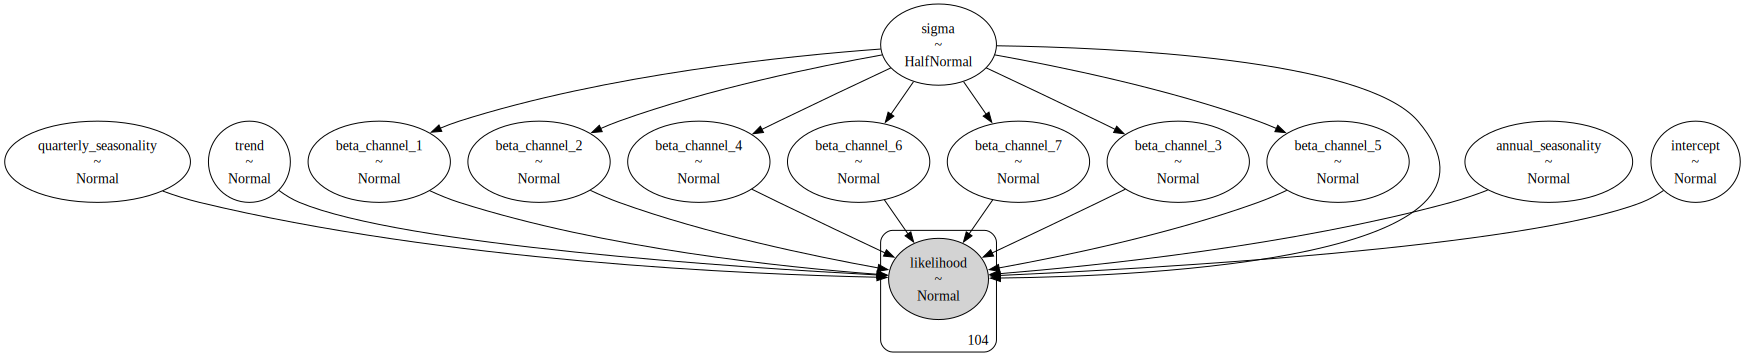

In [50]:
pm.model_to_graphviz(mmm_model)

In [66]:
with mmm_model:
    prior_samples = pm.sample_prior_predictive(100)

Sampling: [annual_seasonality, beta_channel_1, beta_channel_2, beta_channel_3, beta_channel_4, beta_channel_5, beta_channel_6, beta_channel_7, intercept, likelihood, quarterly_seasonality, sigma, trend]


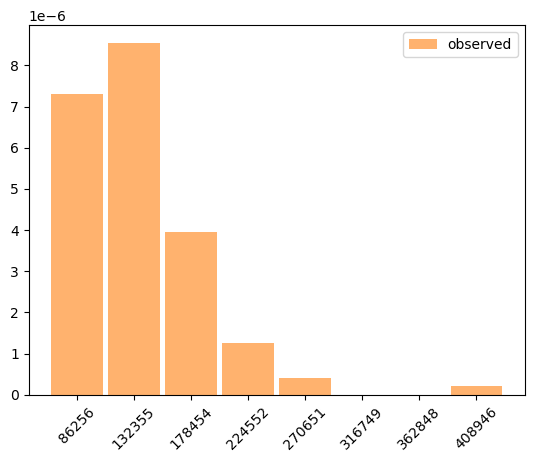

In [68]:

az.plot_dist(
    data["revenue"].values,
    kind="hist",
    color="C1",
    hist_kwargs={"alpha": 0.6},
    label="observed",
)

plt.xticks(rotation=45);

In [54]:
with mmm_model:
    idata = pm.sample(1000, tune=2000, random_seed=42)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, intercept, beta_channel_1, beta_channel_2, beta_channel_3, beta_channel_4, beta_channel_5, beta_channel_6, beta_channel_7, annual_seasonality, quarterly_seasonality, trend]


Output()

Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 81 seconds.


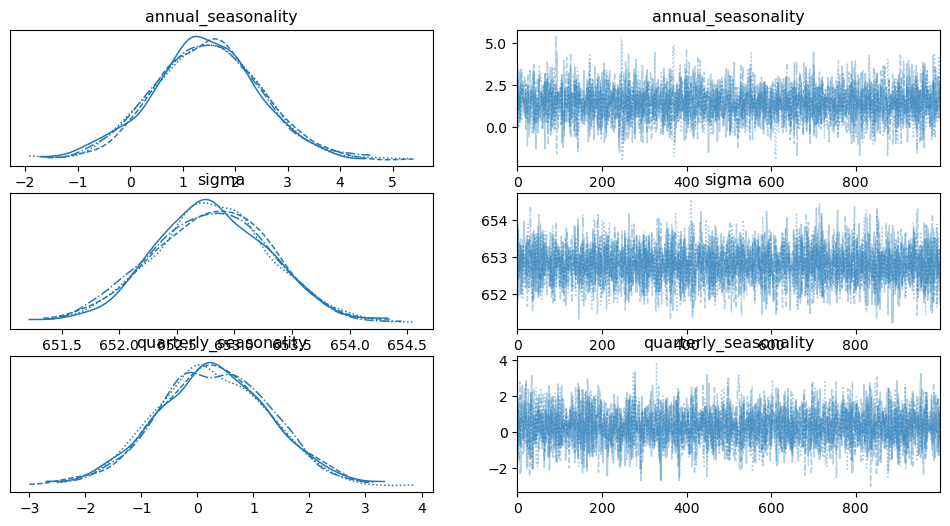

In [55]:
az.plot_trace(idata, var_names=["annual_seasonality", "sigma", "quarterly_seasonality"]);

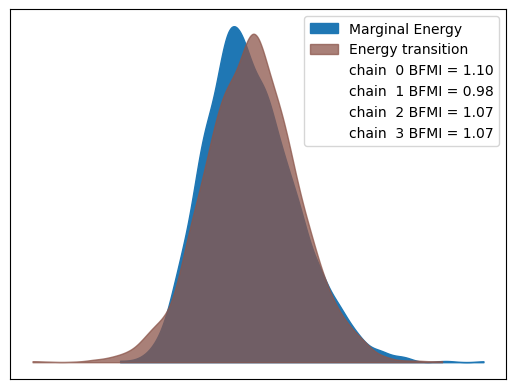

In [56]:
az.plot_energy(idata);